# Fit Smoothed Disperser Attenuation Ratio study for HD111980


Study the true transmission wrt transmission in simulatio 

- author Sylvie Dagoret-Campagne
- creation date : May 2018
- update : May 17th 2018
- affliliation : CNRS/IN2P3
- project : DESC-LSST

- need to increase the number of files to be open:

    ulimit -a
    
    ulimit -n 2048
    
    ulimit -Sn 10000

In [171]:
!ulimit -a

core file size          (blocks, -c) 0
data seg size           (kbytes, -d) unlimited
file size               (blocks, -f) unlimited
max locked memory       (kbytes, -l) unlimited
max memory size         (kbytes, -m) unlimited
open files                      (-n) 2048
pipe size            (512 bytes, -p) 1
stack size              (kbytes, -s) 8192
cpu time               (seconds, -t) unlimited
max user processes              (-u) 1418
virtual memory          (kbytes, -v) unlimited


## Setup

### Notebook style

In [172]:
#from IPython.core.display import HTML
#def css_styling():
#    styles = open("../../styles/custom.css", "r").read()
#    return HTML(styles)
#css_styling()

### import

In [173]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import sys
import os
import pandas as pd
import glob
from matplotlib.backends.backend_pdf import PdfPages 

In [174]:
from scipy import interpolate

In [175]:
import seaborn as sns

In [176]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Figure style

In [177]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),   #defines the default image size
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [178]:
plt.rcParams.update({'figure.max_open_warning': 0}) # to see a large number of files

## Initialisation

### Spectractor

In [179]:
PATH_SPECTRACTOR='../../../Spectractor'
PATH_SPECTRACTORSIM='../../../SpectractorSim'
PATH_SPECTRACTORANAATM='../../../SpectractorAnaAtm/common_tools'
PATH_GMAOMERRA='../../merra2'

In [180]:
sys.path.append(PATH_SPECTRACTOR)
sys.path.append(PATH_SPECTRACTORSIM)
sys.path.append(PATH_SPECTRACTORANAATM)
sys.path.append(PATH_GMAOMERRA)

In [181]:
from spectractor import *
from spectractorsim import *
from libspecana import *

## Input spectra

### LogBook

In [182]:
file_logbook_csv=os.path.join(PATH_SPECTRACTOR,'ctiofulllogbook_jun2017_v4.csv')

In [183]:
df_ctio_lbk=pd.read_csv(file_logbook_csv,sep=';')

In [184]:
df_ctio_lbk.columns

Index([u'Unnamed: 0', u'date', u'subdir', u'index', u'object', u'filter',
       u'disperser', u'airmass', u'exposure', u'focus', u'seeing', u'P', u'T',
       u'RH', u'W', u'file', u'Obj-posXpix', u'Obj-posYpix', u'Dx', u'Dy',
       u'comment', u'skip'],
      dtype='object')

In [185]:
df_ctio_lbk=df_ctio_lbk.reindex(columns=['date','index','P','T','RH','airmass','seeing','exposure','object','filter','disperser','focus','W','subdir','file']).set_index('date').sort_index()

### Spectra Data

In [186]:
home=os.getenv('HOME')

In [187]:
path_data=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod2')
#path_data=os.path.join('/sps/lsst/data/AtmosphericCalibration','CTIODataJune2017_reduced_RG715_v2_prod1')

In [188]:
All_Subdirs=np.array(['data_28may17','data_29may17','data_30may17','data_31may17','data_01jun17','data_02jun17',
            'data_03jun17','data_04jun17','data_06jun17','data_08jun17','data_09jun17','data_10jun17',
            'data_12jun17','data_13jun17'])

In [189]:
Flag_Photometric_Nights=np.array([False,False,True,False,False,False,False,False,False,True,False,True,True,False])

In [190]:
photometric_indexes=np.where(Flag_Photometric_Nights)[0]

In [191]:
print 'Photometric indexes : ',photometric_indexes

Photometric indexes :  [ 2  9 11 12]


In [192]:
print 'Photometric nights : ',All_Subdirs[photometric_indexes]

Photometric nights :  ['data_30may17' 'data_08jun17' 'data_10jun17' 'data_12jun17']


### Sim spectra

In [193]:
PATH_SPECTRACTORSIM

'../../../SpectractorAnaAtm/common_tools/../../SpectractorSim'

In [194]:
# laptop:
#path_sim=os.path.join(PATH_SPECTRACTORSIM,'sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')

# CCIN2P3:
#path_sim=PATH_SPECTRACTORSIM+'/sim_prod/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra'
# Office desktop
home=os.getenv('HOME')
#path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra')
path_sim=os.path.join(home,'DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2')

In [195]:
path_sim

'/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2'

## Selection of night

In [196]:
date="20170530"

In [197]:
idx_sel_subdir=2

In [198]:
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

### Logbook

In [199]:
all_obs=df_ctio_lbk.loc[(df_ctio_lbk["subdir"]==All_Subdirs[idx_sel_subdir])].sort_index()

In [200]:
all_obs_extr=all_obs[["index","object"]]

### Wavelength correction

In [201]:
FLAG_WL_CORRECTION=True # specify if correction on wavelength can be performed from input file
file_wavelengthshift="../wavelength_shift.csv"
wlshift=pd.read_csv(file_wavelengthshift)

In [202]:
wlshift.head()

index   wlshift
0     57 -8.482812
1     58 -3.067819
2     60 -8.745157
3     61 -2.088560
4     62 -2.113683

### path for spectra

In [203]:
path_spectra=os.path.join(path_data,All_Subdirs[idx_sel_subdir])
path_spectrasim=os.path.join(path_sim,All_Subdirs[idx_sel_subdir])

### find filename for data spectra

In [204]:
search_string=os.path.join(path_spectra,'*.fits')
all_spectrafiles=glob.glob(search_string)
all_spectrafiles=sorted(all_spectrafiles)

### extract the index from the data spectra filename

In [205]:
#SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
all_sel_indexes=[]
for ffn in all_spectrafiles:
    all_sel_indexes.append(get_index_from_filename(ffn,SelectTagRe))
all_sel_indexes=np.array(all_sel_indexes)    

### extract the logbook rows corrsponding to the spectra

- use the indexes obtained to extract the relevant rows from the logbook

In [206]:
sel_obs=all_obs.loc[all_obs['index'].isin(all_sel_indexes)]

In [207]:
sel_obs.head()

index    P    T  RH airmass seeing exposure  \
date                                                                   
2017-05-31T00:00:26.147     57  783  9,3  26   1,053   1,14       60   
2017-05-31T00:02:18.596     58  783  9,3  26   1,051   0,94       60   
2017-05-31T00:06:14.000     60  783  9,1  26   1,047  1,018       60   
2017-05-31T00:08:06.454     61  783  9,2  26   1,045  0,939       60   
2017-05-31T00:09:58.852     62  783  9,1  26   1,044  0,846       60   

                           object filter disperser  focus    W        subdir  \
date                                                                           
2017-05-31T00:00:26.147  HD111980    dia    Ron400  12450  5,7  data_30may17   
2017-05-31T00:02:18.596  HD111980    dia   Thor300  12450  5,5  data_30may17   
2017-05-31T00:06:14.000  HD111980    dia    Ron400  12450  5,7  data_30may17   
2017-05-31T00:08:06.454  HD111980    dia   Thor300  12450  5,5  data_30may17   
2017-05-31T00:09:58.852  HD111980    dia   HoloPhP  12450  5,8  data_30may17   

                                            file  
date                                              
2017-05-31T00:00:26.147  reduc_20170530_057.fits  
2017-05-31T00:02:18.596  reduc_20170530_058.fits  
2017-05-31T00:06:14.000  reduc_20170530_060.fits  
2017-05-31T00:08:06.454  reduc_20170530_061.fits  
2017-05-31T00:09:58.852  reduc_20170530_062.fits

In [208]:
sel_obs.tail()

index    P     T  RH airmass seeing exposure  \
date                                                                    
2017-05-31T10:33:46.896    280  782    11  20   1,018  0,793       60   
2017-05-31T10:35:39.245    281  782  11,2  20   1,019  0,793       60   
2017-05-31T10:37:31.598    282  782    11  20   1,021  0,793       60   
2017-05-31T10:39:24.046    283  782    11  20   1,022  0,793      120   
2017-05-31T10:42:16.450    284  782    11  20   1,024  0,793      120   

                           object filter disperser  focus     W        subdir  \
date                                                                            
2017-05-31T10:33:46.896  HD205905    dia    Ron400  12400  14,5  data_30may17   
2017-05-31T10:35:39.245  HD205905    dia   Thor300  12400  13,1  data_30may17   
2017-05-31T10:37:31.598  HD205905    dia   HoloPhP  12400  12,5  data_30may17   
2017-05-31T10:39:24.046  HD205905    dia  HoloPhAg  12400  12,8  data_30may17   
2017-05-31T10:42:16.450  HD205905    dia  HoloAmAg  12400  13,2  data_30may17   

                                            file  
date                                              
2017-05-31T10:33:46.896  reduc_20170530_280.fits  
2017-05-31T10:35:39.245  reduc_20170530_281.fits  
2017-05-31T10:37:31.598  reduc_20170530_282.fits  
2017-05-31T10:39:24.046  reduc_20170530_283.fits  
2017-05-31T10:42:16.450  reduc_20170530_284.fits

### Quick view on the kind of sources

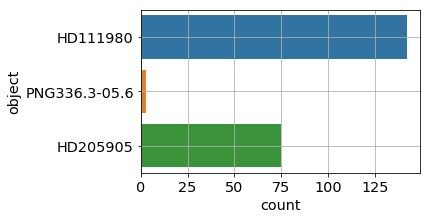

In [209]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel_obs)
plt.grid(True)

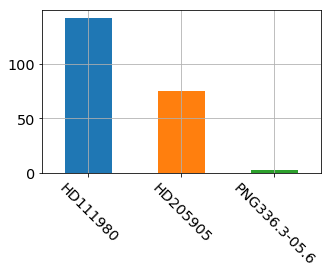

In [210]:
plt.figure(figsize=(5,3))
sel_obs['object'].value_counts().plot(kind='bar',rot=0)
plt.xticks(rotation=-45)
plt.grid(True)

### Remove bad spectra

In [211]:
bad_obs_0=sel_obs.loc[sel_obs['index'].isin([57])]

In [212]:
bad_obs_0

index    P    T  RH airmass seeing exposure  \
date                                                                   
2017-05-31T00:00:26.147     57  783  9,3  26   1,053   1,14       60   

                           object filter disperser  focus    W        subdir  \
date                                                                           
2017-05-31T00:00:26.147  HD111980    dia    Ron400  12450  5,7  data_30may17   

                                            file  
date                                              
2017-05-31T00:00:26.147  reduc_20170530_057.fits

### Remove bad sources

- remove star **PNG336.3-05.6**

In [213]:
bad_obs=sel_obs.loc[sel_obs['object'].isin(['PNG336.3-05.6','HD205905'])]
bad_indexes=bad_obs["index"]

In [214]:
bad_obs

index    P     T  RH airmass seeing exposure  \
date                                                                    
2017-05-31T05:56:35.901    200  783   9,3  23   1,089  0,829      300   
2017-05-31T06:05:21.701    201  783   9,4  23   1,095  0,737      600   
2017-05-31T07:03:12.652    205  783   9,5  24   1,158  0,941      600   
2017-05-31T07:54:38.806    210  782   9,5  23   1,101  0,793       60   
2017-05-31T07:56:31.293    211  782   9,4  24   1,097  0,793       60   
2017-05-31T07:58:23.653    212  782   9,5  24   1,094  0,793       60   
2017-05-31T08:00:16.053    213  782   9,7  23    1,09  0,793      120   
2017-05-31T08:03:08.495    214  782   9,6  23   1,085  0,793      120   
2017-05-31T08:06:00.847    215  782   9,6  23    1,08  0,793       60   
2017-05-31T08:07:53.254    216  782   9,8  23   1,077  0,793       60   
2017-05-31T08:09:45.655    217  782   9,8  23   1,074  0,793       60   
2017-05-31T08:11:37.854    218  782   9,6  23   1,071  0,793      120   
2017-05-31T08:14:30.301    219  782   9,7  23   1,067  0,793      120   
2017-05-31T08:17:22.698    220  782   9,6  23   1,063  0,793       60   
2017-05-31T08:19:15.101    221  782   9,5  23    1,06  0,793       60   
2017-05-31T08:21:07.405    222  782   9,6  23   1,057  0,793       60   
2017-05-31T08:22:59.809    223  782   9,8  23   1,055  0,793      120   
2017-05-31T08:25:52.205    224  782   9,6  23   1,051  0,793      120   
2017-05-31T08:28:44.549    225  782   9,6  23   1,048  0,793       60   
2017-05-31T08:30:37.007    226  782   9,5  23   1,045  0,793       60   
2017-05-31T08:32:29.446    227  782   9,6  23   1,043  0,793       60   
2017-05-31T08:34:21.908    228  782   9,8  23   1,041  0,793      120   
2017-05-31T08:37:14.395    229  782   9,8  23   1,038  0,793      120   
2017-05-31T08:40:06.801    230  782   9,7  23   1,035  0,793       60   
2017-05-31T08:41:59.205    231  782   9,9  23   1,033  0,793       60   
2017-05-31T08:43:51.549    232  782   9,9  23   1,031  0,793       60   
2017-05-31T08:45:44.007    233  782    10  23   1,029  0,793      120   
2017-05-31T08:48:36.303    234  782    10  22   1,027  0,793      120   
2017-05-31T08:51:28.895    235  782    10  22   1,024  0,793       60   
2017-05-31T08:53:21.253    236  782    10  22   1,022  0,793       60   
...                        ...  ...   ...  ..     ...    ...      ...   
2017-05-31T09:36:57.303    255  782  10,5  21   1,002  0,793       60   
2017-05-31T09:38:49.697    256  782  10,5  21   1,002  0,793       60   
2017-05-31T09:40:42.049    257  782  10,6  21   1,001  0,793       60   
2017-05-31T09:42:34.505    258  782  10,8  21   1,001  0,793      120   
2017-05-31T09:45:26.803    259  782  10,9  21   1,001  0,793      120   
2017-05-31T09:48:19.197    260  782  10,9  21   1,001  0,793       60   
2017-05-31T09:50:11.505    261  782    11  21   1,001  0,793       60   
2017-05-31T09:52:03.850    262  782    11  21   1,001  0,793       60   
2017-05-31T09:53:56.298    263  782    11  21   1,002  0,793      120   
2017-05-31T09:56:48.701    264  782  10,9  21   1,002  0,793      120   
2017-05-31T09:59:41.005    265  782  10,7  21   1,002  0,793       60   
2017-05-31T10:01:33.456    266  782  10,8  21   1,003  0,793       60   
2017-05-31T10:03:25.899    267  782  10,9  20   1,003  0,793       60   
2017-05-31T10:05:18.254    268  782    11  20   1,004  0,793      120   
2017-05-31T10:08:10.496    269  782    11  20   1,005  0,793      120   
2017-05-31T10:11:02.902    270  782  11,1  20   1,006  0,793       60   
2017-05-31T10:12:55.245    271  782  11,1  20   1,006  0,793       60   
2017-05-31T10:14:47.702    272  782  11,2  20   1,007  0,793       60   
2017-05-31T10:16:40.105    273  782  11,3  20   1,008  0,793      120   
2017-05-31T10:19:32.499    274  782  11,1  20   1,009  0,793      120   
2017-05-31T10:22:24.800    275  782  11,3  20   1,011  0,793       60   
2017-05-31T10:24:17.302    276  782  11,2  20   1,012  0,793       60   
2017-05-31

In [215]:
bad_indexes=bad_obs.loc[:,"index"]

In [216]:
bad_indexes.index

Index([u'2017-05-31T05:56:35.901', u'2017-05-31T06:05:21.701',
       u'2017-05-31T07:03:12.652', u'2017-05-31T07:54:38.806',
       u'2017-05-31T07:56:31.293', u'2017-05-31T07:58:23.653',
       u'2017-05-31T08:00:16.053', u'2017-05-31T08:03:08.495',
       u'2017-05-31T08:06:00.847', u'2017-05-31T08:07:53.254',
       u'2017-05-31T08:09:45.655', u'2017-05-31T08:11:37.854',
       u'2017-05-31T08:14:30.301', u'2017-05-31T08:17:22.698',
       u'2017-05-31T08:19:15.101', u'2017-05-31T08:21:07.405',
       u'2017-05-31T08:22:59.809', u'2017-05-31T08:25:52.205',
       u'2017-05-31T08:28:44.549', u'2017-05-31T08:30:37.007',
       u'2017-05-31T08:32:29.446', u'2017-05-31T08:34:21.908',
       u'2017-05-31T08:37:14.395', u'2017-05-31T08:40:06.801',
       u'2017-05-31T08:41:59.205', u'2017-05-31T08:43:51.549',
       u'2017-05-31T08:45:44.007', u'2017-05-31T08:48:36.303',
       u'2017-05-31T08:51:28.895', u'2017-05-31T08:53:21.253',
       u'2017-05-31T08:55:13.701', u'2017-05-31T08:57:0

In [217]:
bad_indexes.values

array([200, 201, 205, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
       272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284])

### Concatenate bad obs

In [218]:
bad_obs=pd.concat([bad_obs,bad_obs_0])

In [219]:
bad_obs

index    P     T  RH airmass seeing exposure  \
date                                                                    
2017-05-31T05:56:35.901    200  783   9,3  23   1,089  0,829      300   
2017-05-31T06:05:21.701    201  783   9,4  23   1,095  0,737      600   
2017-05-31T07:03:12.652    205  783   9,5  24   1,158  0,941      600   
2017-05-31T07:54:38.806    210  782   9,5  23   1,101  0,793       60   
2017-05-31T07:56:31.293    211  782   9,4  24   1,097  0,793       60   
2017-05-31T07:58:23.653    212  782   9,5  24   1,094  0,793       60   
2017-05-31T08:00:16.053    213  782   9,7  23    1,09  0,793      120   
2017-05-31T08:03:08.495    214  782   9,6  23   1,085  0,793      120   
2017-05-31T08:06:00.847    215  782   9,6  23    1,08  0,793       60   
2017-05-31T08:07:53.254    216  782   9,8  23   1,077  0,793       60   
2017-05-31T08:09:45.655    217  782   9,8  23   1,074  0,793       60   
2017-05-31T08:11:37.854    218  782   9,6  23   1,071  0,793      120   
2017-05-31T08:14:30.301    219  782   9,7  23   1,067  0,793      120   
2017-05-31T08:17:22.698    220  782   9,6  23   1,063  0,793       60   
2017-05-31T08:19:15.101    221  782   9,5  23    1,06  0,793       60   
2017-05-31T08:21:07.405    222  782   9,6  23   1,057  0,793       60   
2017-05-31T08:22:59.809    223  782   9,8  23   1,055  0,793      120   
2017-05-31T08:25:52.205    224  782   9,6  23   1,051  0,793      120   
2017-05-31T08:28:44.549    225  782   9,6  23   1,048  0,793       60   
2017-05-31T08:30:37.007    226  782   9,5  23   1,045  0,793       60   
2017-05-31T08:32:29.446    227  782   9,6  23   1,043  0,793       60   
2017-05-31T08:34:21.908    228  782   9,8  23   1,041  0,793      120   
2017-05-31T08:37:14.395    229  782   9,8  23   1,038  0,793      120   
2017-05-31T08:40:06.801    230  782   9,7  23   1,035  0,793       60   
2017-05-31T08:41:59.205    231  782   9,9  23   1,033  0,793       60   
2017-05-31T08:43:51.549    232  782   9,9  23   1,031  0,793       60   
2017-05-31T08:45:44.007    233  782    10  23   1,029  0,793      120   
2017-05-31T08:48:36.303    234  782    10  22   1,027  0,793      120   
2017-05-31T08:51:28.895    235  782    10  22   1,024  0,793       60   
2017-05-31T08:53:21.253    236  782    10  22   1,022  0,793       60   
...                        ...  ...   ...  ..     ...    ...      ...   
2017-05-31T09:38:49.697    256  782  10,5  21   1,002  0,793       60   
2017-05-31T09:40:42.049    257  782  10,6  21   1,001  0,793       60   
2017-05-31T09:42:34.505    258  782  10,8  21   1,001  0,793      120   
2017-05-31T09:45:26.803    259  782  10,9  21   1,001  0,793      120   
2017-05-31T09:48:19.197    260  782  10,9  21   1,001  0,793       60   
2017-05-31T09:50:11.505    261  782    11  21   1,001  0,793       60   
2017-05-31T09:52:03.850    262  782    11  21   1,001  0,793       60   
2017-05-31T09:53:56.298    263  782    11  21   1,002  0,793      120   
2017-05-31T09:56:48.701    264  782  10,9  21   1,002  0,793      120   
2017-05-31T09:59:41.005    265  782  10,7  21   1,002  0,793       60   
2017-05-31T10:01:33.456    266  782  10,8  21   1,003  0,793       60   
2017-05-31T10:03:25.899    267  782  10,9  20   1,003  0,793       60   
2017-05-31T10:05:18.254    268  782    11  20   1,004  0,793      120   
2017-05-31T10:08:10.496    269  782    11  20   1,005  0,793      120   
2017-05-31T10:11:02.902    270  782  11,1  20   1,006  0,793       60   
2017-05-31T10:12:55.245    271  782  11,1  20   1,006  0,793       60   
2017-05-31T10:14:47.702    272  782  11,2  20   1,007  0,793       60   
2017-05-31T10:16:40.105    273  782  11,3  20   1,008  0,793      120   
2017-05-31T10:19:32.499    274  782  11,1  20   1,009  0,793      120   
2017-05-31T10:22:24.800    275  782  11,3  20   1,011  0,793       60   
2017-05-31T10:24:17.302    276  782  11,2  20   1,012  0,793       60   
2017-05-31T10:26:09.797    277  782  11,2  20   1,013  0,793       60   
2017-05-31

In [220]:
bad_obs.sort_values(by="index",inplace=True)

In [221]:
bad_indexes=bad_obs.loc[:,"index"]

In [222]:
bad_indexes.index

Index([u'2017-05-31T00:00:26.147', u'2017-05-31T05:56:35.901',
       u'2017-05-31T06:05:21.701', u'2017-05-31T07:03:12.652',
       u'2017-05-31T07:54:38.806', u'2017-05-31T07:56:31.293',
       u'2017-05-31T07:58:23.653', u'2017-05-31T08:00:16.053',
       u'2017-05-31T08:03:08.495', u'2017-05-31T08:06:00.847',
       u'2017-05-31T08:07:53.254', u'2017-05-31T08:09:45.655',
       u'2017-05-31T08:11:37.854', u'2017-05-31T08:14:30.301',
       u'2017-05-31T08:17:22.698', u'2017-05-31T08:19:15.101',
       u'2017-05-31T08:21:07.405', u'2017-05-31T08:22:59.809',
       u'2017-05-31T08:25:52.205', u'2017-05-31T08:28:44.549',
       u'2017-05-31T08:30:37.007', u'2017-05-31T08:32:29.446',
       u'2017-05-31T08:34:21.908', u'2017-05-31T08:37:14.395',
       u'2017-05-31T08:40:06.801', u'2017-05-31T08:41:59.205',
       u'2017-05-31T08:43:51.549', u'2017-05-31T08:45:44.007',
       u'2017-05-31T08:48:36.303', u'2017-05-31T08:51:28.895',
       u'2017-05-31T08:53:21.253', u'2017-05-31T08:55:1

In [223]:
bad_indexes.values

array([ 57, 200, 201, 205, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
       258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
       271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284])

- keep stars **HD111980**, **HD205905**

In [224]:
sel2_obs=sel_obs.loc[sel_obs['object'].isin(['HD111980'])]

In [225]:
sel2_obs=sel2_obs[sel2_obs.index !=57]      # REMOVE 57

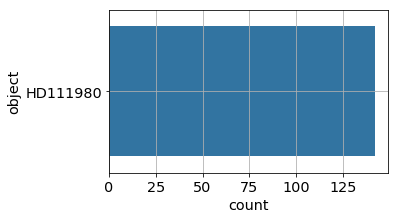

In [226]:
plt.figure(figsize=(5,3))
sns.countplot(y='object', data=sel2_obs)
plt.grid(True)

#### Make a list of the object names

In [227]:
list_of_objects=sel2_obs['object'].values

In [228]:
list_of_objects=set(list_of_objects)

In [229]:
list_of_objects=list(list_of_objects)

In [230]:
list_of_objects_str=','.join(list_of_objects)

### find filename for sim spectra

In [231]:
path_sim1=os.path.join(path_spectrasim,'clearsky')
path_sim2=os.path.join(path_spectrasim,'standard')
path_sim3=os.path.join(path_spectrasim,'merra2')

In [232]:
search_string=os.path.join(path_sim1,'*.fits')
all_simspectrafiles1=glob.glob(search_string)
all_simspectrafiles1=sorted(all_simspectrafiles1)

In [233]:
all_simspectrafiles1[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_30may17/clearsky/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_30may17/clearsky/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_30may17/clearsky/specsim_20170530_060_spectrum.fits']

In [234]:
search_string=os.path.join(path_sim2,'*.fits')
all_simspectrafiles2=glob.glob(search_string)
all_simspectrafiles2=sorted(all_simspectrafiles2)

In [235]:
all_simspectrafiles2[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_30may17/standard/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_30may17/standard/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_30may17/standard/specsim_20170530_060_spectrum.fits']

In [236]:
search_string=os.path.join(path_sim3,'*.fits')
all_simspectrafiles3=glob.glob(search_string)
all_simspectrafiles3=sorted(all_simspectrafiles3)

In [237]:
all_simspectrafiles3[:3]

['/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_30may17/merra2/specsim_20170530_057_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_30may17/merra2/specsim_20170530_058_spectrum.fits',
 '/Users/dagoret/DATA/CTIODataJune2017_reduced_RG715_v2_prod1_SimSpectra_v2/data_30may17/merra2/specsim_20170530_060_spectrum.fits']

# Remove bad indexes

In [238]:
file_toremove=[]
SelectTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_spectrafiles:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_spectrafiles.remove(f)        

 remove  reduc_20170530_057_spectrum.fits
 remove  reduc_20170530_200_spectrum.fits
 remove  reduc_20170530_201_spectrum.fits
 remove  reduc_20170530_205_spectrum.fits
 remove  reduc_20170530_210_spectrum.fits
 remove  reduc_20170530_211_spectrum.fits
 remove  reduc_20170530_212_spectrum.fits
 remove  reduc_20170530_213_spectrum.fits
 remove  reduc_20170530_214_spectrum.fits
 remove  reduc_20170530_215_spectrum.fits
 remove  reduc_20170530_216_spectrum.fits
 remove  reduc_20170530_217_spectrum.fits
 remove  reduc_20170530_218_spectrum.fits
 remove  reduc_20170530_219_spectrum.fits
 remove  reduc_20170530_220_spectrum.fits
 remove  reduc_20170530_221_spectrum.fits
 remove  reduc_20170530_222_spectrum.fits
 remove  reduc_20170530_223_spectrum.fits
 remove  reduc_20170530_224_spectrum.fits
 remove  reduc_20170530_225_spectrum.fits
 remove  reduc_20170530_226_spectrum.fits
 remove  reduc_20170530_227_spectrum.fits
 remove  reduc_20170530_228_spectrum.fits
 remove  reduc_20170530_229_spectr

In [239]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles1:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles1.remove(f)   

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_200_spectrum.fits
 remove  specsim_20170530_201_spectrum.fits
 remove  specsim_20170530_205_spectrum.fits
 remove  specsim_20170530_210_spectrum.fits
 remove  specsim_20170530_211_spectrum.fits
 remove  specsim_20170530_212_spectrum.fits
 remove  specsim_20170530_213_spectrum.fits
 remove  specsim_20170530_214_spectrum.fits
 remove  specsim_20170530_215_spectrum.fits
 remove  specsim_20170530_216_spectrum.fits
 remove  specsim_20170530_217_spectrum.fits
 remove  specsim_20170530_218_spectrum.fits
 remove  specsim_20170530_219_spectrum.fits
 remove  specsim_20170530_220_spectrum.fits
 remove  specsim_20170530_221_spectrum.fits
 remove  specsim_20170530_222_spectrum.fits
 remove  specsim_20170530_223_spectrum.fits
 remove  specsim_20170530_224_spectrum.fits
 remove  specsim_20170530_225_spectrum.fits
 remove  specsim_20170530_226_spectrum.fits
 remove  specsim_20170530_227_spectrum.fits
 remove  specsim_20170530_228_sp

In [240]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles2:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles2.remove(f)

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_200_spectrum.fits
 remove  specsim_20170530_201_spectrum.fits
 remove  specsim_20170530_205_spectrum.fits
 remove  specsim_20170530_210_spectrum.fits
 remove  specsim_20170530_211_spectrum.fits
 remove  specsim_20170530_212_spectrum.fits
 remove  specsim_20170530_213_spectrum.fits
 remove  specsim_20170530_214_spectrum.fits
 remove  specsim_20170530_215_spectrum.fits
 remove  specsim_20170530_216_spectrum.fits
 remove  specsim_20170530_217_spectrum.fits
 remove  specsim_20170530_218_spectrum.fits
 remove  specsim_20170530_219_spectrum.fits
 remove  specsim_20170530_220_spectrum.fits
 remove  specsim_20170530_221_spectrum.fits
 remove  specsim_20170530_222_spectrum.fits
 remove  specsim_20170530_223_spectrum.fits
 remove  specsim_20170530_224_spectrum.fits
 remove  specsim_20170530_225_spectrum.fits
 remove  specsim_20170530_226_spectrum.fits
 remove  specsim_20170530_227_spectrum.fits
 remove  specsim_20170530_228_sp

In [241]:
file_toremove=[]
SelectTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)
for ffn in all_simspectrafiles3:
    fn=ffn.split('/')[-1]
    sel_index= int(re.findall(SelectTagRe,fn)[0])
    if sel_index in bad_indexes.values:
        print ' remove ', fn
        file_toremove.append(ffn)
for f in file_toremove:
    all_simspectrafiles3.remove(f)

 remove  specsim_20170530_057_spectrum.fits
 remove  specsim_20170530_200_spectrum.fits
 remove  specsim_20170530_201_spectrum.fits
 remove  specsim_20170530_205_spectrum.fits
 remove  specsim_20170530_210_spectrum.fits
 remove  specsim_20170530_211_spectrum.fits
 remove  specsim_20170530_212_spectrum.fits
 remove  specsim_20170530_213_spectrum.fits
 remove  specsim_20170530_214_spectrum.fits
 remove  specsim_20170530_215_spectrum.fits
 remove  specsim_20170530_216_spectrum.fits
 remove  specsim_20170530_217_spectrum.fits
 remove  specsim_20170530_218_spectrum.fits
 remove  specsim_20170530_219_spectrum.fits
 remove  specsim_20170530_220_spectrum.fits
 remove  specsim_20170530_221_spectrum.fits
 remove  specsim_20170530_222_spectrum.fits
 remove  specsim_20170530_223_spectrum.fits
 remove  specsim_20170530_224_spectrum.fits
 remove  specsim_20170530_225_spectrum.fits
 remove  specsim_20170530_226_spectrum.fits
 remove  specsim_20170530_227_spectrum.fits
 remove  specsim_20170530_228_sp

# which filters

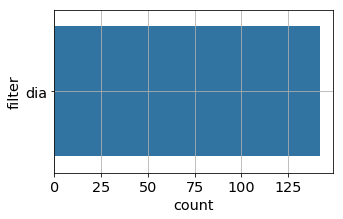

In [242]:
plt.figure(figsize=(5,3))
sns.countplot(y='filter', data=sel2_obs)
plt.grid(True)

# which are the dispersers ?

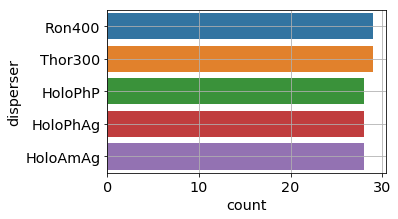

In [243]:
plt.figure(figsize=(5,3))
sns.countplot(y='disperser', data=sel2_obs)
plt.grid(True)

In [244]:
sel_obs_Ron400=sel2_obs.loc[sel2_obs['disperser'].isin(['Ron400'])]

In [245]:
sel_obs_Thor300=sel2_obs.loc[sel2_obs['disperser'].isin(['Thor300'])]

In [246]:
sel_obs_HoloPhP=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhP'])]

In [247]:
sel_obs_HoloPhAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloPhAg'])]

In [248]:
sel_obs_HoloAmAg=sel2_obs.loc[sel2_obs['disperser'].isin(['HoloAmAg'])]

# Show the spectra

In [249]:
# filtering width
Wwidth=11
# Bin width
Bwidth=10

In [250]:
# filtering width
Wwidth=51
# Bin width
Bwidth=50

## Original SED

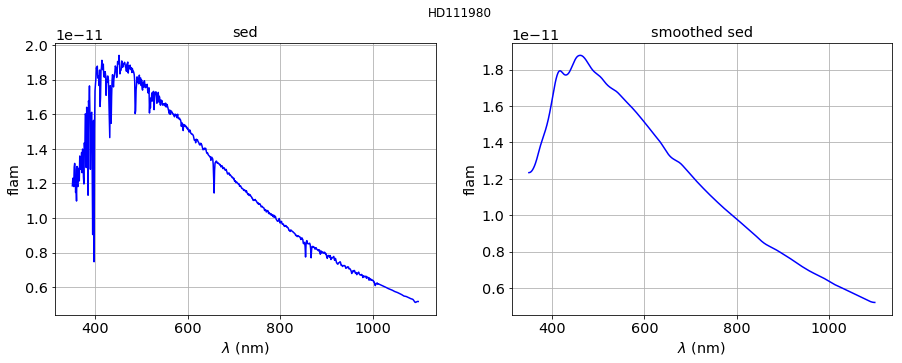

In [251]:
PlotSED(list_of_objects_str,Wwidth=Wwidth,sedunit='flam',scale='lin')

In [252]:
#PlotSED(list_of_objects_str,sedunit='photlam',scale='log')

In [253]:
#PlotSED(list_of_objects_str,sedunit='photnu',scale='log')

<Figure size 720x360 with 0 Axes>

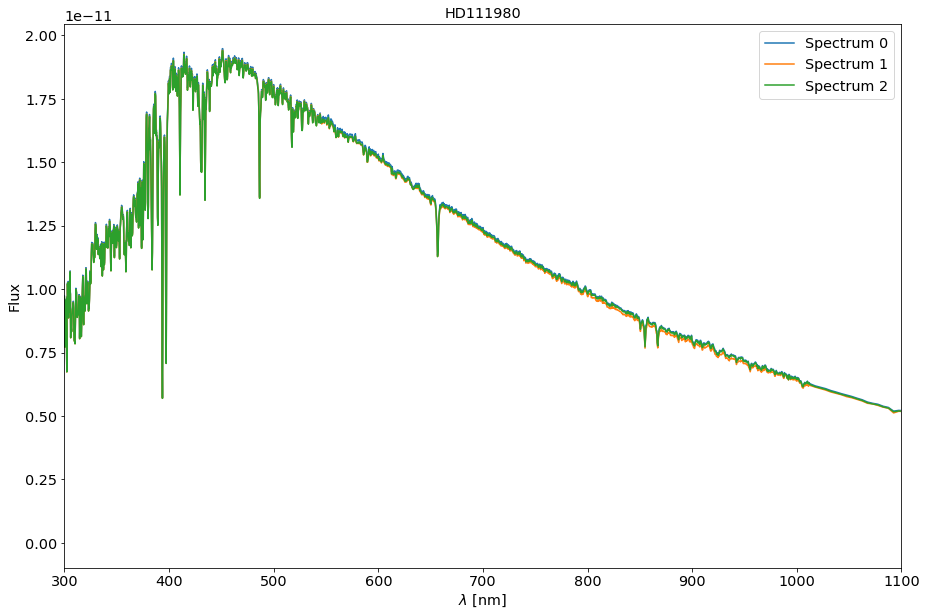

In [254]:
plt.figure(figsize=(10,5))
GetTarget(list_of_objects_str)


## Show the reconstructed spectra

In [255]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
print SearchTagRe

^reduc_20170530_([0-9]+)_spectrum.fits$


### Ronchi 400 spectra

In [256]:
thetitle="Smoothed Reconstructed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

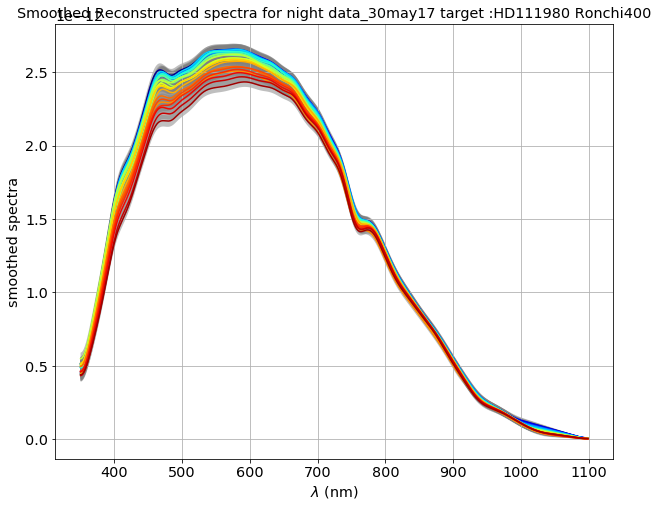

In [257]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=Wwidth)

### Thor 300

In [258]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

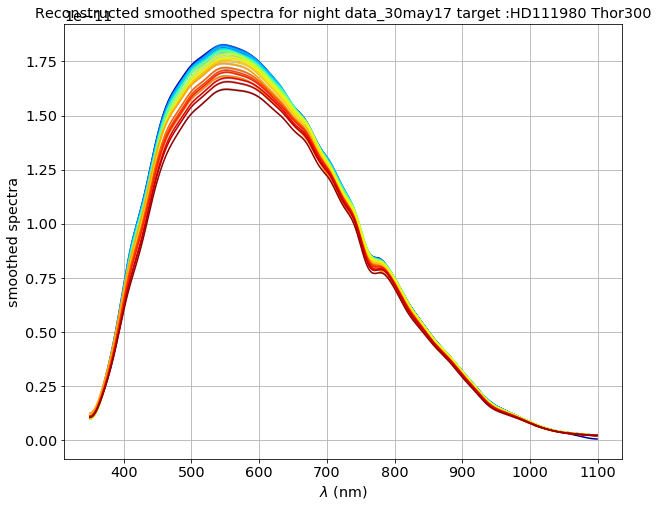

In [259]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=Wwidth)

### HoloPhP

In [260]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

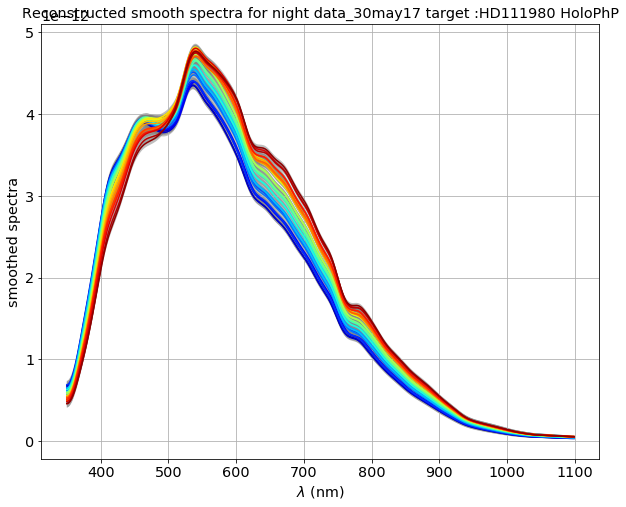

In [261]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=Wwidth)

### HoloPhAg

In [262]:
thetitle="Reconstructed smooth spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

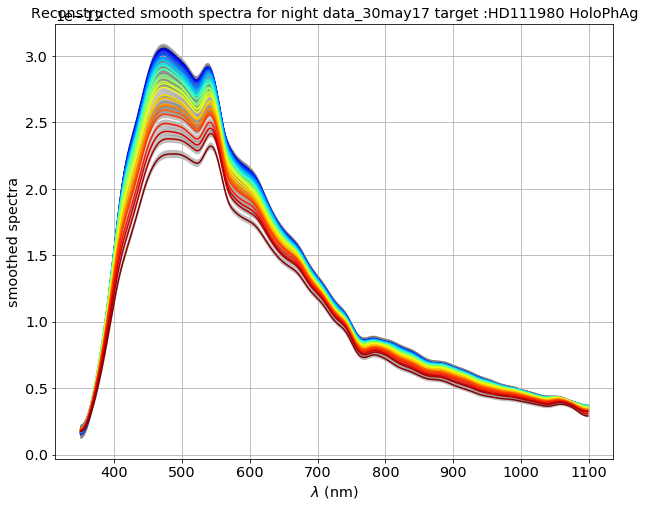

In [263]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=Wwidth)

### HoloAmAg

In [264]:
thetitle="Reconstructed smoothed spectra for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

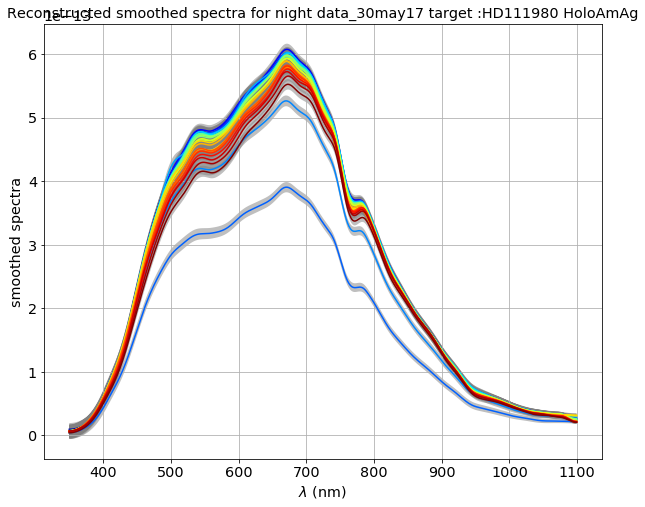

In [265]:
PlotSpectraDataSimSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,Wwidth=Wwidth)

## Show the simulated spectra

In [266]:
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

### Clear sky

In [267]:
thetitle="Smoothed sim spectra for night (clearsky) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

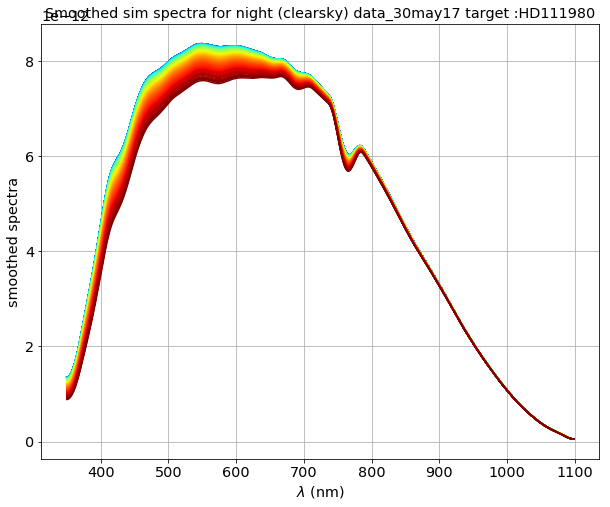

In [268]:
PlotSpectraDataSimSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=Wwidth)

### standard sky

In [269]:
thetitle="Smoothed sim spectra for night (standard) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

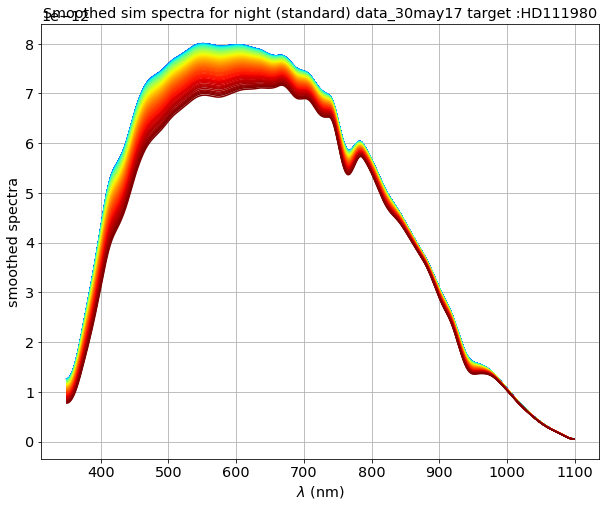

In [270]:
PlotSpectraDataSimSmooth(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=Wwidth)

### merra2 sky

In [271]:
thetitle="Smoothed sim spectra for night (merra2) "+All_Subdirs[idx_sel_subdir]+' target :'+list_of_objects_str

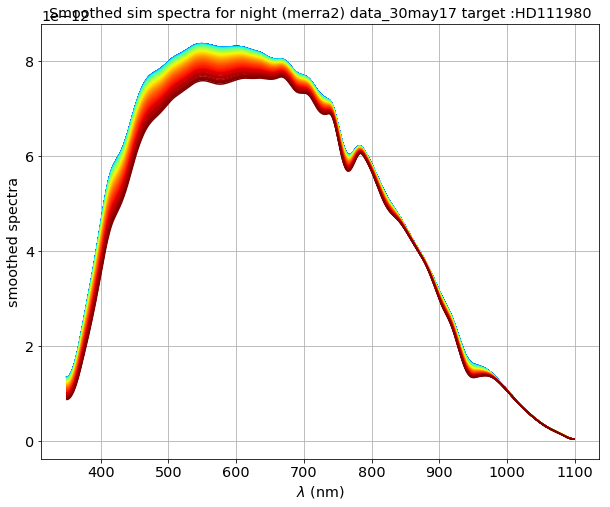

In [272]:
PlotSpectraDataSimSmooth(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,Wwidth=Wwidth)

# Airmass vs image index

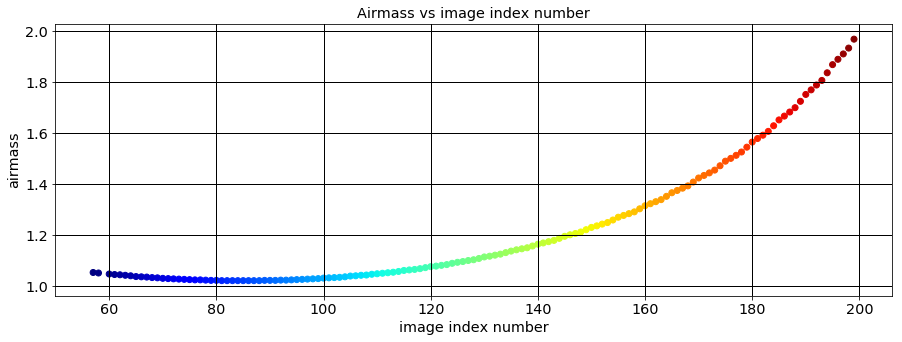

In [273]:
PlotAirmass(sel2_obs)

# Attenuation

In [274]:
# filtering width
Wwidth=11
# Bin width
Bwidth=10

## Ronchi 400

In [275]:
SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)

In [276]:
thetitle="Attenuation Ratio 350-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

In [277]:
#FitSpectraDataSimAttenuationRatioSmooth(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [278]:
thetitle="Binned Ratio Attenuation 350-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

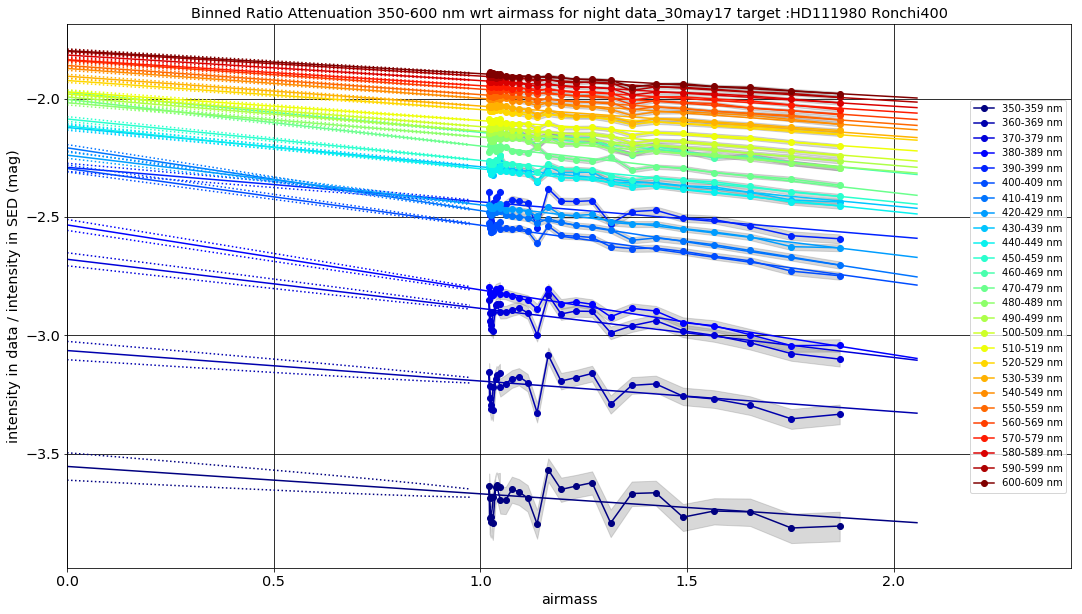

In [279]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=350,ZMAX=600,Wwidth=Wwidth,Bwidth=Bwidth)   

In [280]:
thetitle="Binned Ratio Attenuation 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ronchi400"

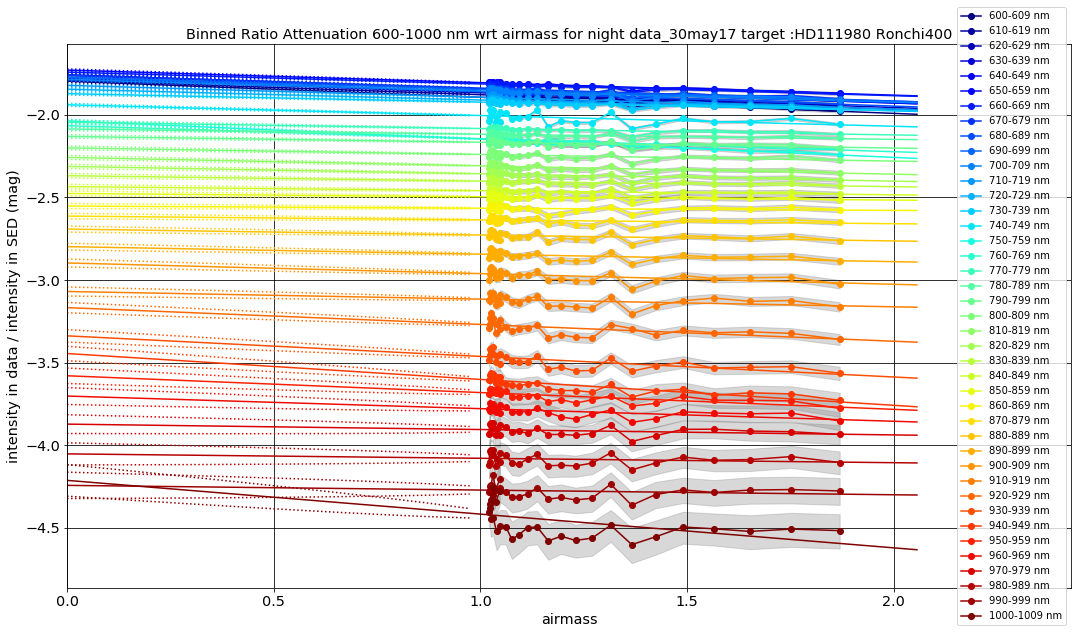

In [281]:
wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_Ron400,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth) 

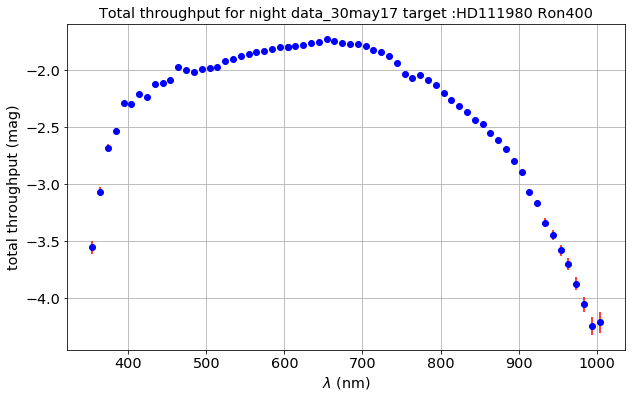

In [282]:
wl=np.concatenate((wl1,wl2))
thrpt=np.concatenate((y1,y2))
err=np.concatenate((ey1,ey2))
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Ron400"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [283]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_Ron400.csv")
df.head()

wl     thrpt       err
0  354.0 -3.554632  0.057940
1  364.0 -3.064697  0.038718
2  374.0 -2.678874  0.027526
3  384.0 -2.533716  0.023094
4  394.0 -2.290189  0.017170

## Thor300

In [284]:
thetitle="Attenuation Ratio 350-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

In [285]:
#FitSpectraDataSimAttenuationRatioSmooth(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [286]:
thetitle="Binned Attenuation Ratio 350-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

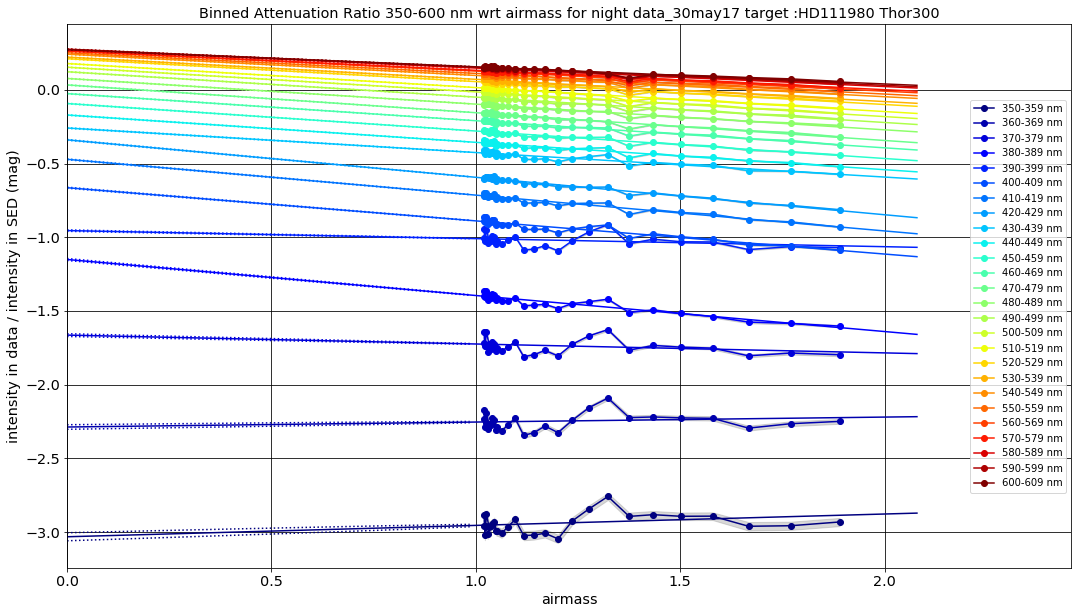

In [287]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=350,ZMAX=600,Wwidth=Wwidth,Bwidth=Bwidth)   

In [288]:
thetitle="Binned Attenuation Ratio 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"

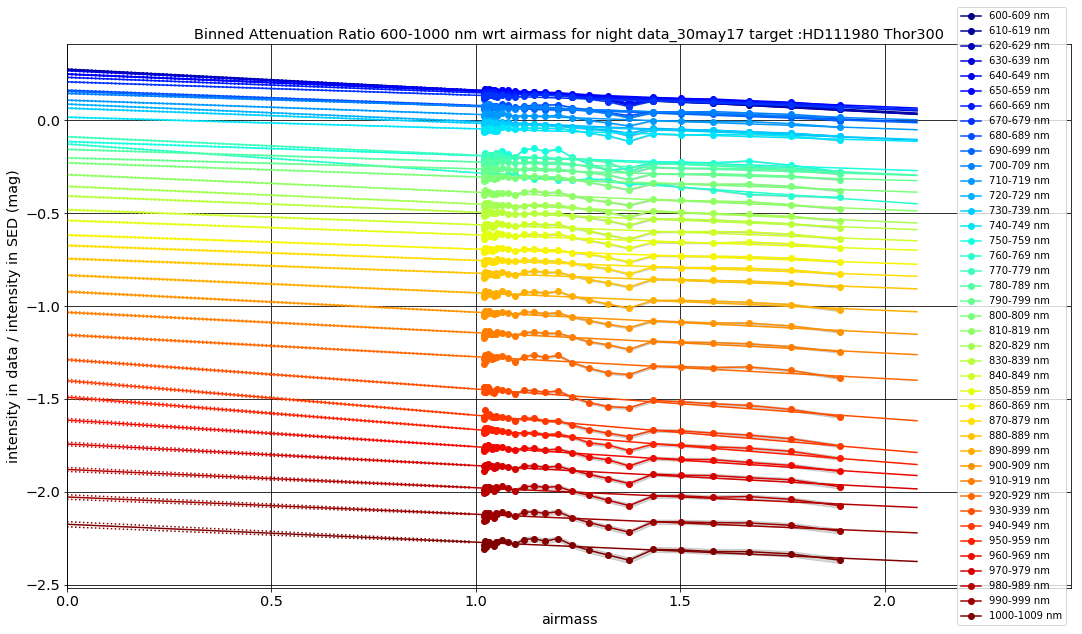

In [289]:
wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_Thor300,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth)   

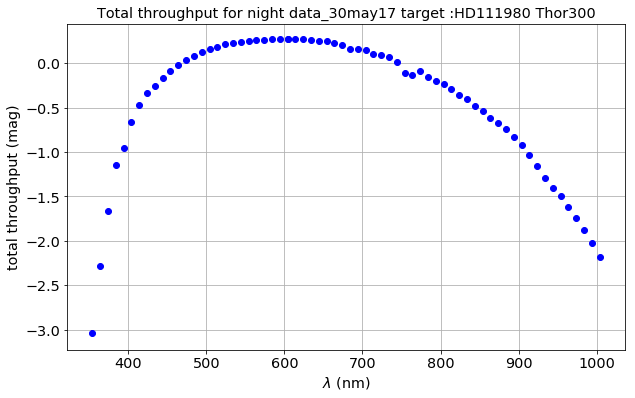

In [290]:
wl=np.concatenate((wl1,wl2))
thrpt=np.concatenate((y1,y2))
err=np.concatenate((ey1,ey2))
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Thor300"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [291]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_Thor300.csv")
df.head()

wl     thrpt       err
0  354.0 -3.031053  0.027246
1  364.0 -2.286801  0.015501
2  374.0 -1.663526  0.009323
3  384.0 -1.150841  0.006769
4  394.0 -0.954821  0.005021

## HoloPhP

In [292]:
thetitle="Attenuation Ratio 350-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

In [293]:
#FitSpectraDataSimAttenuationRatioSmooth(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [294]:
thetitle="Binned Attenuation Ratio 350-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

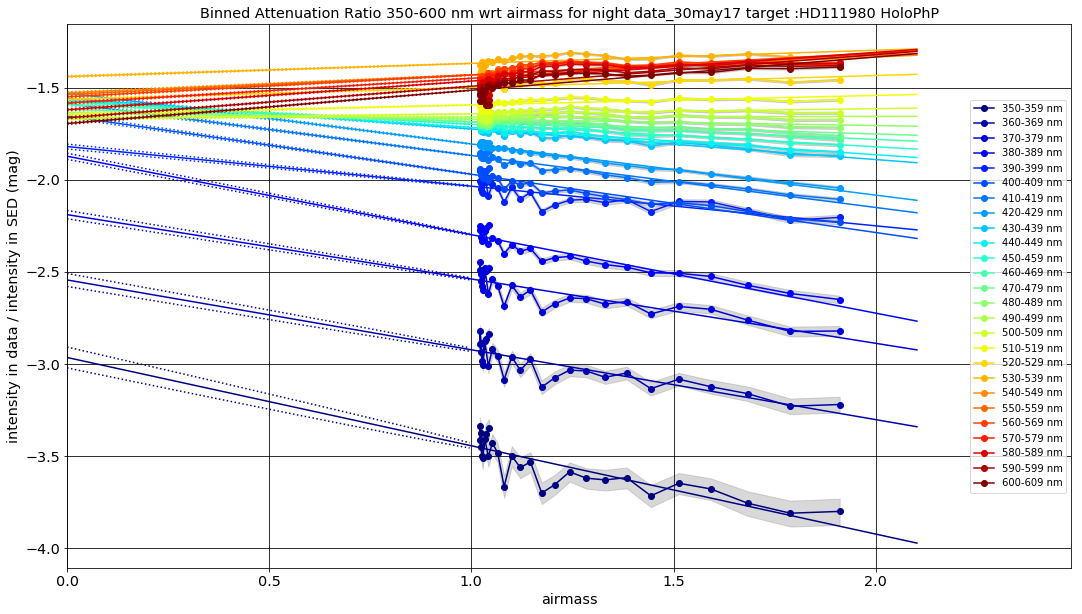

In [295]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=350,ZMAX=600,Wwidth=Wwidth,Bwidth=Bwidth)   

In [296]:
thetitle="Binned Attenuation Ratio 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"

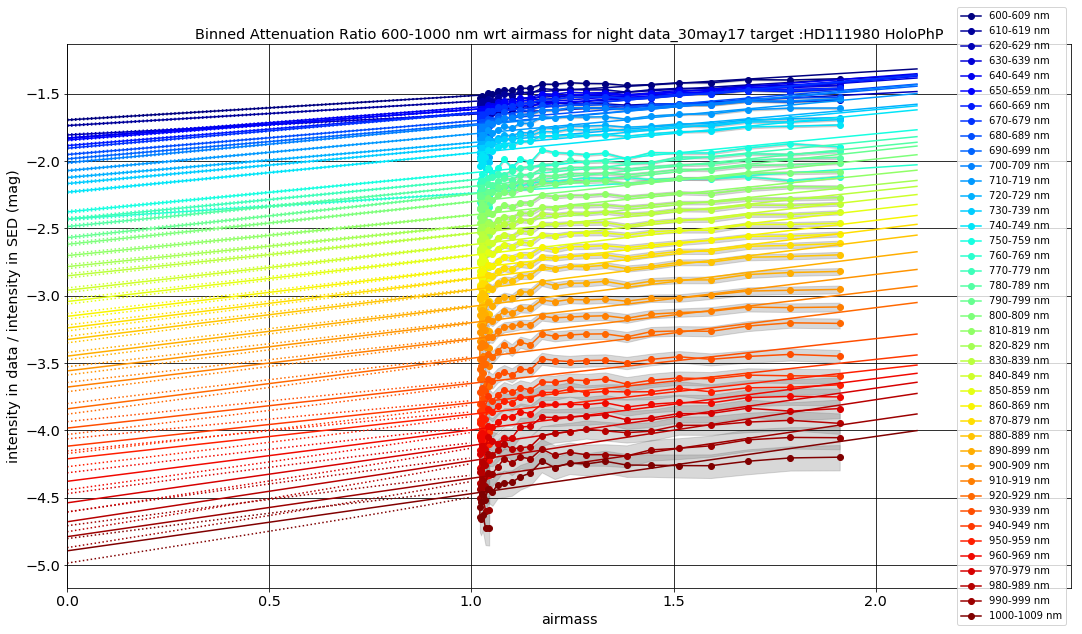

In [297]:
wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloPhP,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth)   

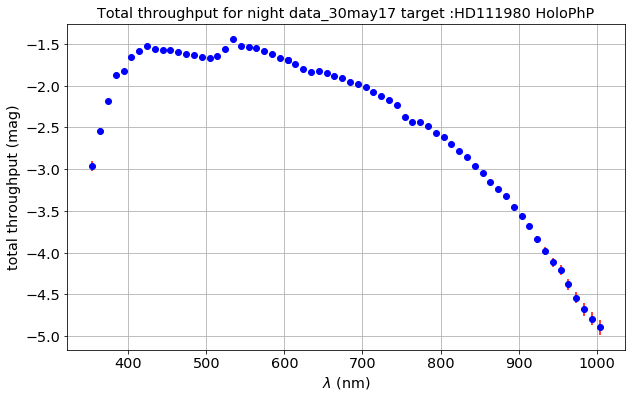

In [298]:
wl=np.concatenate((wl1,wl2))
thrpt=np.concatenate((y1,y2))
err=np.concatenate((ey1,ey2))
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhP"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [299]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_HoloPhP.csv")
df.head()

wl     thrpt       err
0  354.0 -2.964315  0.056591
1  364.0 -2.543544  0.035197
2  374.0 -2.189063  0.022560
3  384.0 -1.872034  0.016653
4  394.0 -1.819543  0.013071

## HoloPhAg

In [300]:
thetitle="Attenuation Ratio 350-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

In [301]:
#FitSpectraDataSimAttenuationRatioSmooth(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [302]:
thetitle="Binned Attenuation Ratio 350-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

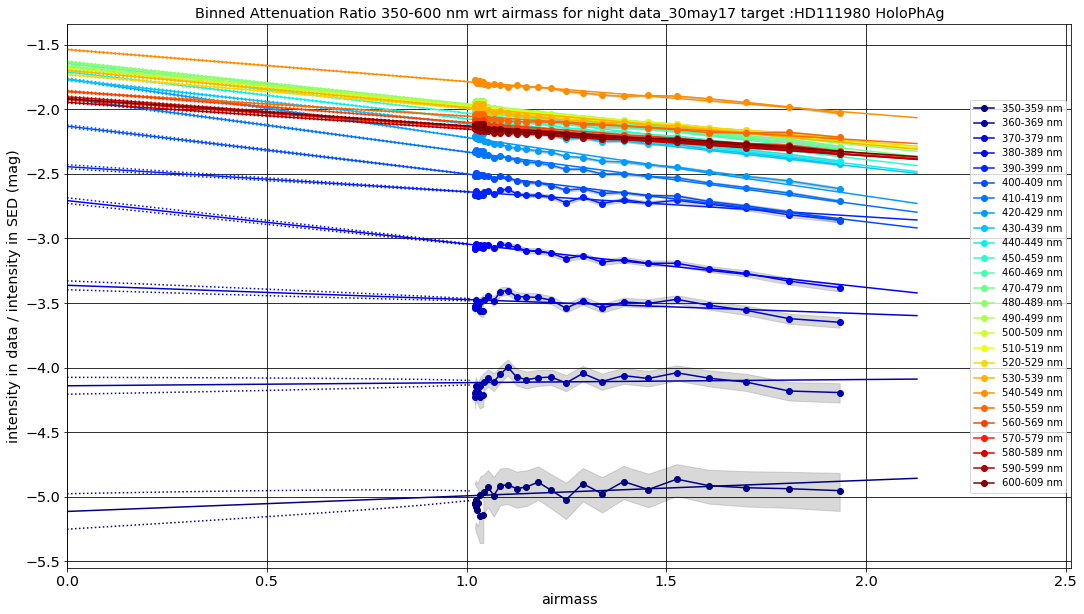

In [303]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=350,ZMAX=600,Wwidth=Wwidth,Bwidth=Bwidth)   

In [304]:
thetitle="Binned Attenuation Ratio 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"

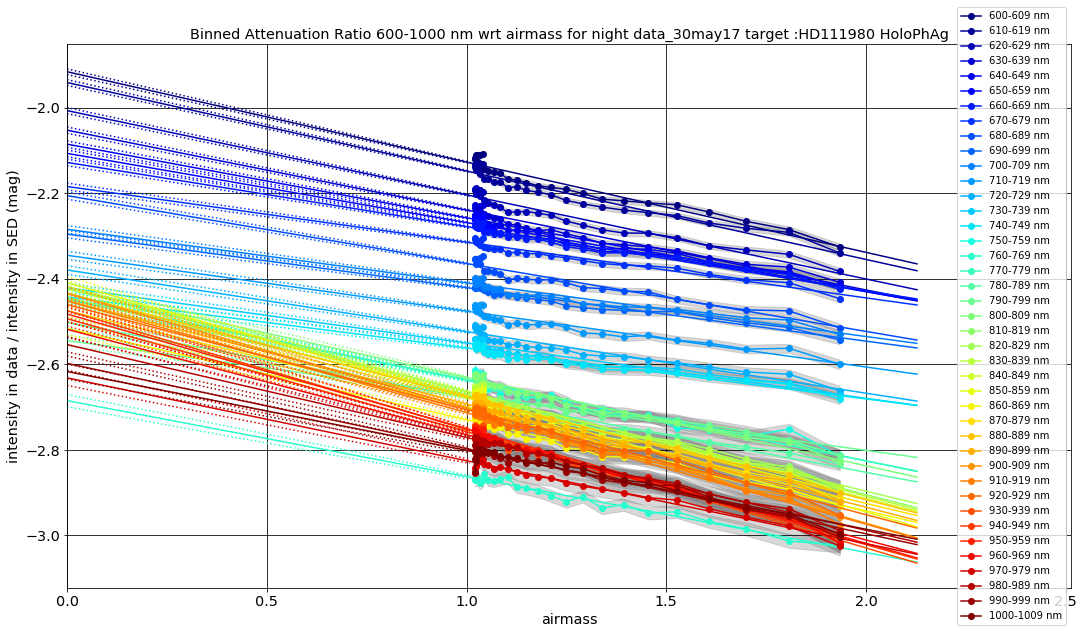

In [305]:
wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloPhAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth)   

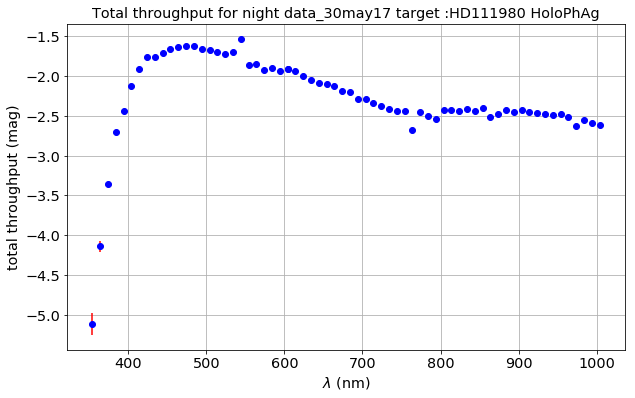

In [306]:
wl=np.concatenate((wl1,wl2))
thrpt=np.concatenate((y1,y2))
err=np.concatenate((ey1,ey2))
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloPhAg"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [307]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_HoloPhAg.csv")
df.head()

wl     thrpt       err
0  354.0 -5.115334  0.137208
1  364.0 -4.141419  0.065448
2  374.0 -3.362586  0.034335
3  384.0 -2.706354  0.022087
4  394.0 -2.443427  0.015528

## HoloAmAg

In [308]:
thetitle="Attenuation Ratio 350-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

In [309]:
#FitSpectraDataSimAttenuationRatioSmooth(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [310]:
thetitle="Binned Attenuation Ratio 400-700 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

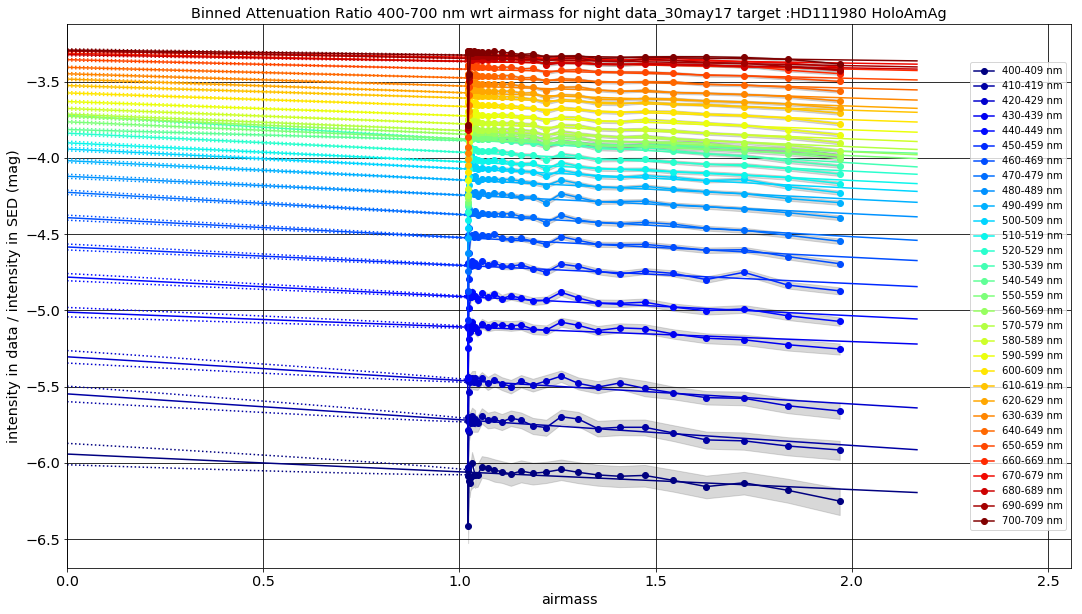

In [311]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=400,ZMAX=700,Wwidth=Wwidth,Bwidth=Bwidth)   

In [312]:
thetitle="Binned Attenuation Ratio 700-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"

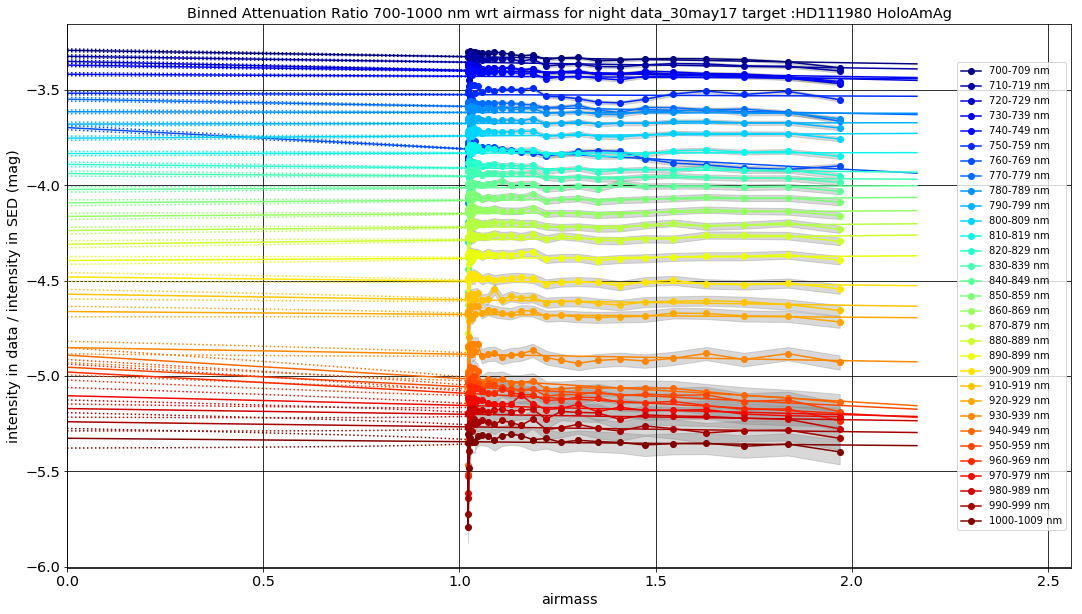

In [313]:
wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_spectrafiles,sel_obs_HoloAmAg,SearchTagRe,wlshift,thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=True,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=700,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth)   

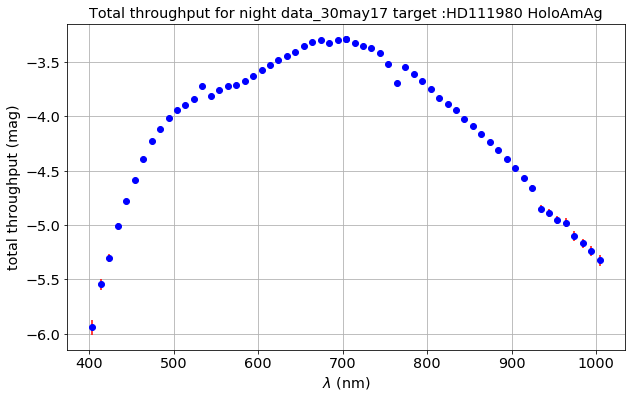

In [314]:
wl=np.concatenate((wl1,wl2))
thrpt=np.concatenate((y1,y2))
err=np.concatenate((ey1,ey2))
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" HoloAmAg"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [315]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_HoloAmAg.csv")
df.head()

wl     thrpt       err
0  404.0 -5.942273  0.070220
1  414.0 -5.547623  0.050883
2  424.0 -5.304421  0.040959
3  434.0 -5.011276  0.030729
4  444.0 -4.781663  0.023571

# Simulation

In [316]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [317]:
#SearchTagRe='^reduc_%s_([0-9]+)_spectrum.fits$' % (date)
SearchTagRe='^specsim_%s_([0-9]+)_spectrum.fits$' % (date)

## Simulation with ClearSky

In [318]:
thetitle="Attenuation Ratio 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky"

In [319]:
#FitSpectraDataSimAttenuationRatioSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=400,XMAX=1000.,YMIN=0,YMAX=0,ZMIN=400,ZMAX=600,Wwidth=51)   

In [320]:
thetitle="Attenuation 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky"

In [321]:
#FitSpectraDataSimAttenuationRatioSmooth(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=51)   

In [322]:
thetitle="Binned Attenuation Ratio 350-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky"

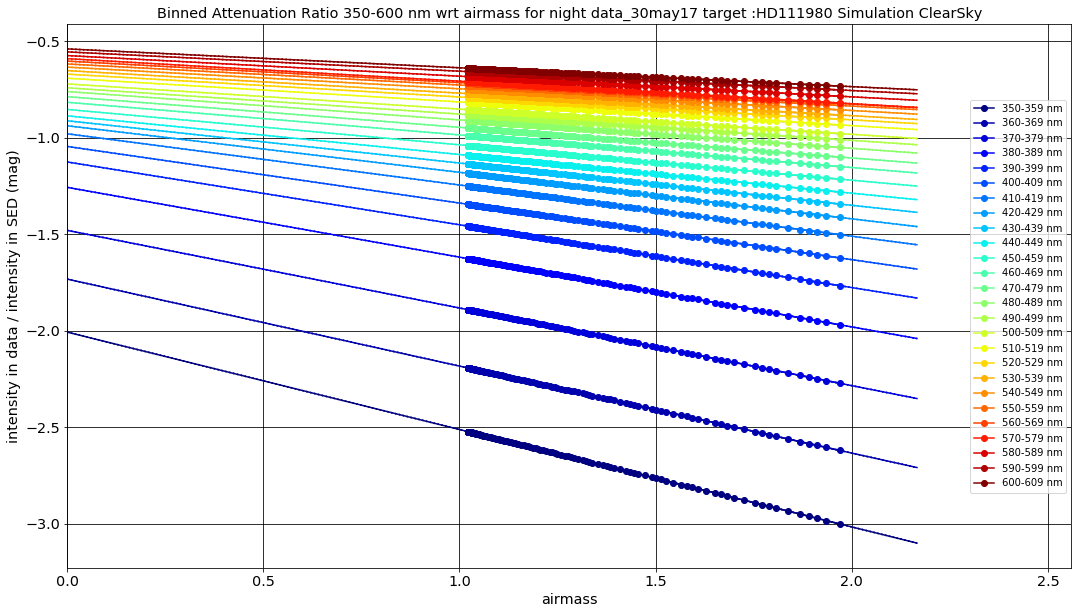

In [323]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=350,ZMAX=600,Wwidth=Wwidth,Bwidth=Bwidth) 

In [324]:
thetitle="Binned Attenuation Ratio 600-1100 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation ClearSky"

FitSpectraDataSimAttenuationRatioSmoothBin : skip bins: 1090 - 1099
FluxBin= [[  7.62233890e-14   5.01118106e-14   2.71272390e-14 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  7.62252143e-14   5.01129806e-14   2.71278587e-14 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  7.62261333e-14   5.01135691e-14   2.71281698e-14 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  7.58310226e-14   4.98603892e-14   2.69941114e-14 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  7.58205587e-14   4.98536860e-14   2.69905630e-14 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  7.58046330e-14   4.98434788e-14   2.69851574e-14 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]


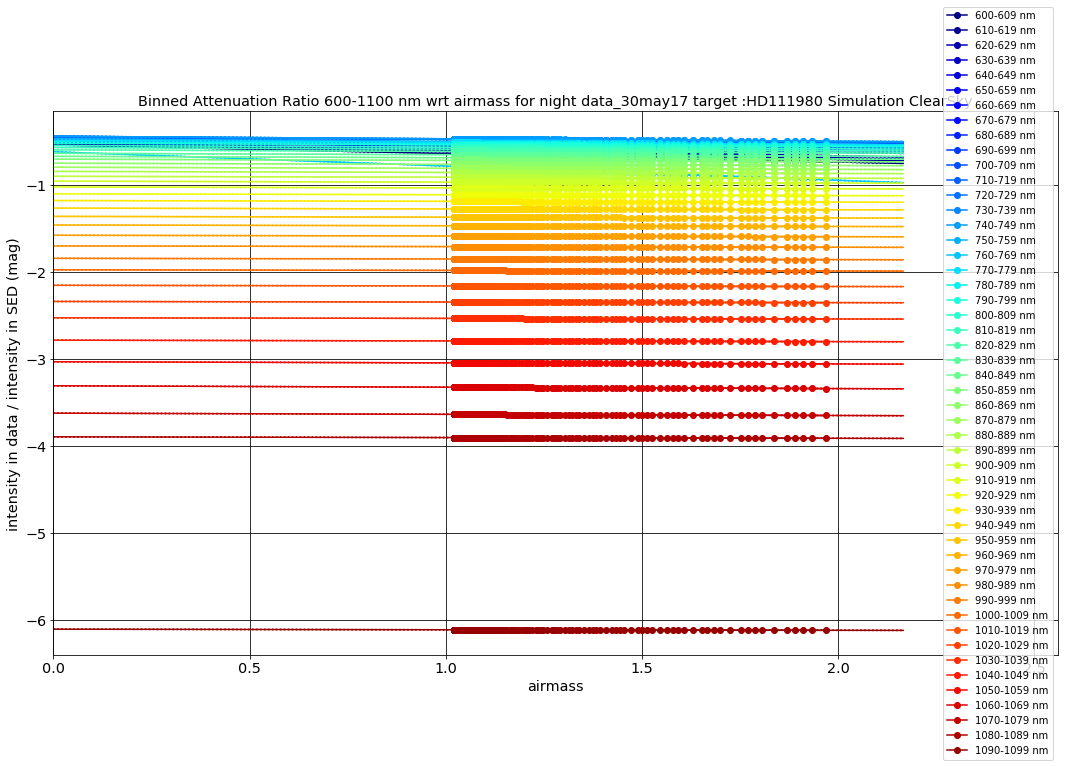

In [325]:
wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles1,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1100,Wwidth=Wwidth,Bwidth=Bwidth) 

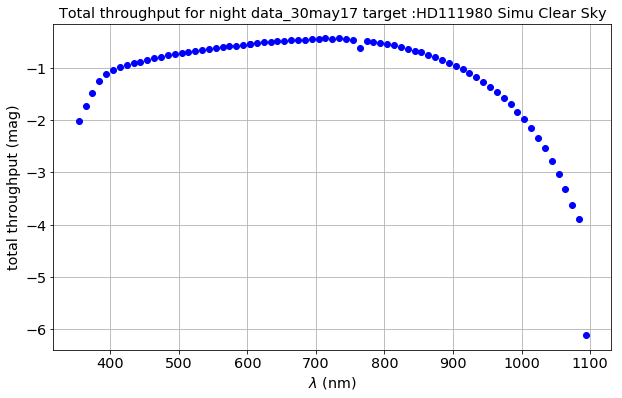

In [326]:
wl=np.concatenate((wl1,wl2))
thrpt=np.concatenate((y1,y2))
err=np.concatenate((ey1,ey2))
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simu Clear Sky"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [327]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_SimClearSky.csv")
df.head()

wl     thrpt  err
0  354.0 -2.007601  0.0
1  364.0 -1.732972  0.0
2  374.0 -1.480428  0.0
3  384.0 -1.257678  0.0
4  394.0 -1.126119  0.0

(400.0, 1000.0)

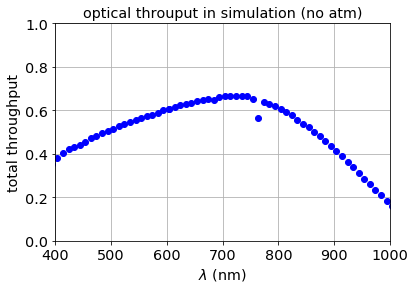

In [328]:
plt.title('optical throuput in simulation (no atm)')
plt.plot(wl,np.power(10,thrpt/2.5),'bo')
plt.xlabel('$\lambda$ (nm)' )
plt.ylabel('total throughput')
plt.grid(b=True, which='both')
plt.ylim(0.,1.)
plt.xlim(400.,1000.)

## Simulation with average Sky

In [329]:
thetitle="Binned Attenuation Ratio 350-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation Average Sky"

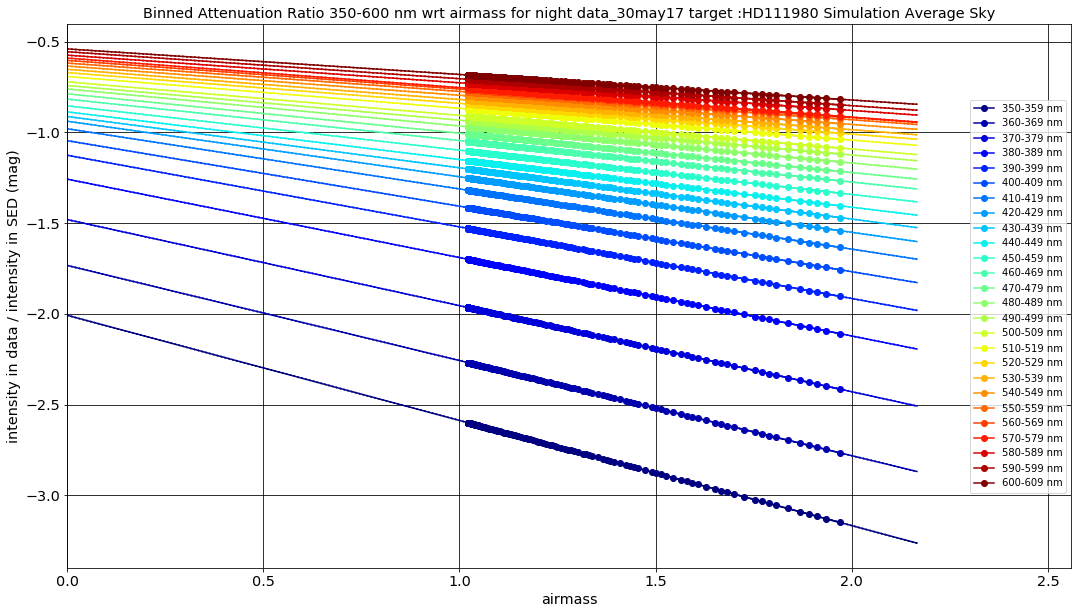

In [330]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=350,ZMAX=600,Wwidth=Wwidth,Bwidth=Bwidth) 

In [331]:
thetitle="Binned Attenuation Ratio 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation Average Sky"

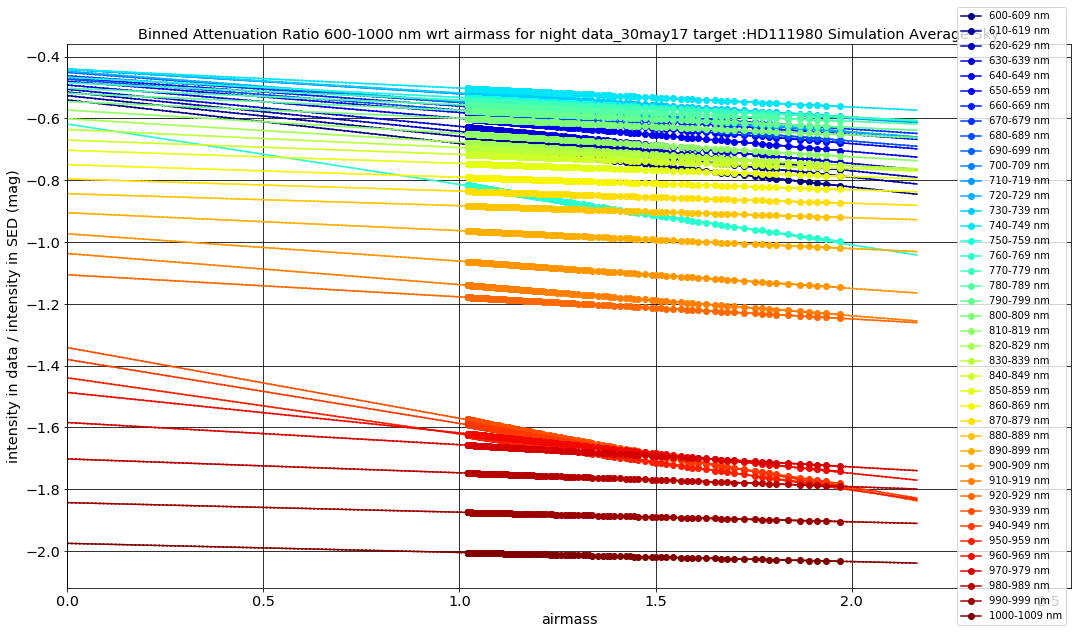

In [332]:
wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles2,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth) 

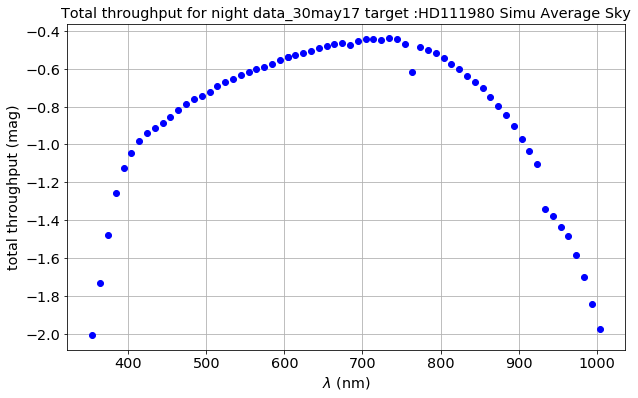

In [333]:
wl=np.concatenate((wl1,wl2))
thrpt=np.concatenate((y1,y2))
err=np.concatenate((ey1,ey2))
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simu Average Sky"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [334]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_SimAverSky.csv")
df.head()

wl     thrpt  err
0  354.0 -2.007612  0.0
1  364.0 -1.732985  0.0
2  374.0 -1.480438  0.0
3  384.0 -1.257688  0.0
4  394.0 -1.126128  0.0

## Simulation with MERRA2 Sky

In [335]:
thetitle="Binned Attenuation Ratio 400-600 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation MERRA2 Sky"

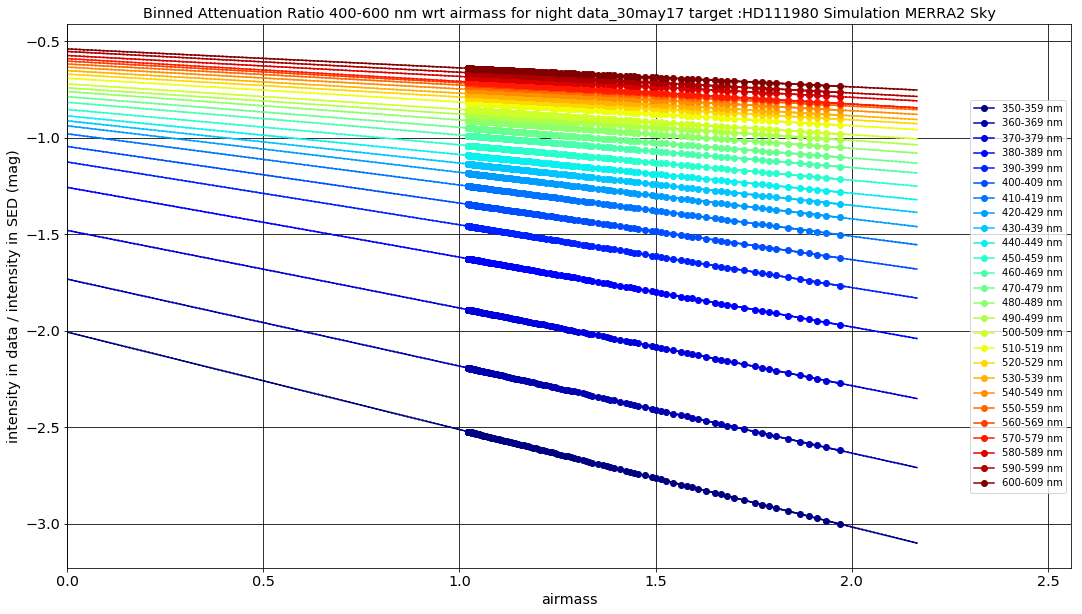

In [336]:
wl1,y1,ey1=FitSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=350,ZMAX=600,Wwidth=Wwidth,Bwidth=Bwidth) 

In [337]:
thetitle="Binned Attenuation Ratio 600-1000 nm wrt airmass for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simulation MERRA2 Sky"

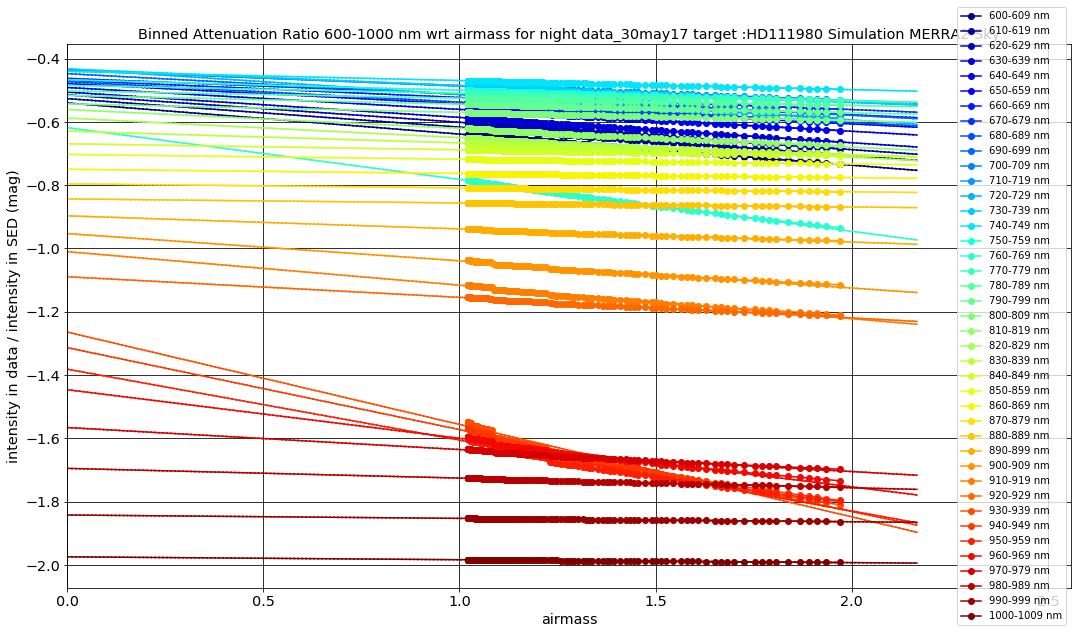

In [338]:
wl2,y2,ey2=FitSpectraDataSimAttenuationRatioSmoothBin(all_simspectrafiles3,sel2_obs,SearchTagRe,np.zeros(len(wlshift)),thetitle,FLAG_WL_CORRECTION,Flag_corr_wl=False,XMIN=0,XMAX=0,YMIN=0,YMAX=0,ZMIN=600,ZMAX=1000,Wwidth=Wwidth,Bwidth=Bwidth) 

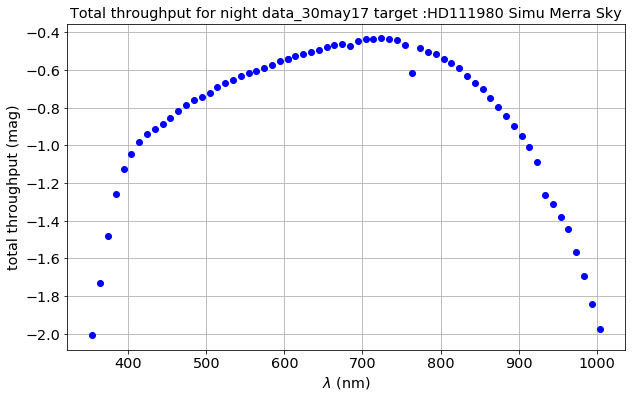

In [339]:
wl=np.concatenate((wl1,wl2))
thrpt=np.concatenate((y1,y2))
err=np.concatenate((ey1,ey2))
thetitle="Total throughput for night "+All_Subdirs[idx_sel_subdir]+" target :"+list_of_objects_str+" Simu Merra Sky"
PlotOpticalThroughput(wl,thrpt,err,thetitle)

In [340]:
df=pd.DataFrame()
df["wl"]=wl
df["thrpt"]=thrpt
df["err"]=err
df.to_csv("thrpt_SimMerra2Sky.csv")
df.head()

wl     thrpt  err
0  354.0 -2.007601  0.0
1  364.0 -1.732972  0.0
2  374.0 -1.480428  0.0
3  384.0 -1.257678  0.0
4  394.0 -1.126119  0.0